#### Metrics Documentation (Classification and Regression)

#https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

In [4]:
import os 
import json
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from collections import defaultdict
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import roc_auc_score, mean_squared_error

In [5]:
import os
# Office
#os.chdir('C:\\Users\\Administrator\\Desktop\\Data\\Loan Prediction')
#data = pd.read_csv('LoanTrain.csv')

# Personal
os.chdir('C:\\Users\\prudi\\Desktop\\Data Sets\\Loan Prediction')
data = pd.read_csv('Loan Prediction Train.csv')

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
import pickle

class PreProcessing(BaseEstimator, TransformerMixin):


    def __init__(self):
        pass

    def transform(self, df):

        pred_var = ['Gender','Married','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area']
        
        df = df[pred_var].reset_index(drop=True)
        
        #df['Dependents'] = df['Dependents'].fillna(0)
        df['Self_Employed'] = df['Self_Employed'].fillna('No')
        df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(self.term_mean_)
        df['Credit_History'] = df['Credit_History'].fillna(1)
        df['Married'] = df['Married'].fillna('No')
        df['Gender'] = df['Gender'].fillna('Male')
        df['LoanAmount'] = df['LoanAmount'].fillna(self.amt_mean_)
        
        #loading a MINMAX Scaler from a file called minmax_pickle.pkl
        MinMaxpickle_in = open("C:\\Users\\prudi\\Desktop\\Data Sets\\Loan Prediction\\minmax_pickle.pkl","rb")
        MinmaxScaler_dict = pickle.load(MinMaxpickle_in)
        df['ApplicantIncome']=pd.DataFrame(MinmaxScaler_dict['ApplicantIncome'].fit_transform(df[['ApplicantIncome']]))
        
        #loading a One Hot Encoder Scaler from a file called binarizer_pickle.pkl
        Onehotpickle_in = open("C:\\Users\\prudi\\Desktop\\Data Sets\\Loan Prediction\\binarizer_pickle.pkl","rb")
        Onehot_dict = pickle.load(Onehotpickle_in)
        d1=pd.DataFrame(Onehot_dict['Self_Employed'].fit_transform(df[['Self_Employed']]))
        d2=pd.DataFrame(Onehot_dict['Married'].fit_transform(df[['Married']]))
        d3=pd.DataFrame(Onehot_dict['Gender'].fit_transform(df[['Gender']]))
        d=pd.concat([d1,d2,d3],axis=1)
        col=['Self_Employed_0','Married_0','Gender_0']
        d.columns=col
        df.drop(['Self_Employed','Married','Gender'],axis=1,inplace=True)
        df=pd.concat([df,d],axis=1)
        
        ## Loading a Label encoder scaler from a file called labelencoder_pickle
        Labelencoderpickle_in = open("C:\\Users\\prudi\\Desktop\\Data Sets\\Loan Prediction\\labelencoder_pickle.pkl","rb")
        Labelencoder_dict = pickle.load(Labelencoderpickle_in)
        df['Education']=pd.DataFrame(Labelencoder_dict['Education'].fit_transform(df[['Education']]))
        df['Property_Area']=pd.DataFrame(Labelencoder_dict['Property_Area'].fit_transform(df[['Property_Area']]))
        df['Credit_History']=pd.DataFrame(Labelencoder_dict['Credit_History'].fit_transform(df[['Credit_History']]))
        #df['Dependents']=pd.DataFrame(Labelencoder_dict['Dependents'].fit_transform(df[['Dependents']]))
        #df['Loan_Status']=pd.DataFrame(Labelencoder_dict['Loan_Status'].fit_transform(df[['Loan_Status']]))
        return df.as_matrix()

    def fit(self, df, y=None, **fit_params):
        self.term_mean_ = df['Loan_Amount_Term'].mean()
        self.amt_mean_ = df['LoanAmount'].mean()
        return self

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
pred_var = ['Loan_ID','Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area']
X_train, X_test, y_train, y_test = train_test_split(data[pred_var], data['Loan_Status'], test_size=0.25, random_state=42)

In [23]:
print(X_train.shape)

(460, 12)


In [24]:
preprocess = PreProcessing()

In [25]:
preprocess.fit(X_train)

PreProcessing()

In [26]:
data_transformed_xtrain = preprocess.transform(X_train)

In [27]:
data_transformed_xtrain
print(data_transformed_xtrain.shape)

(460, 10)


In [28]:
pred_var = ['Education','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area','Self_Employed_0','Married_0','Gender_0']
data_transformed_xtrain=pd.DataFrame(data_transformed_xtrain,columns=pred_var)
data_transformed_xtrain.head()
#data_transformed['Dependents'].unique()

,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Self_Employed_0,Married_0,Gender_0
0,1.0,0.038627,1820.0,81.0,360.0,1.0,2.0,0.0,1.0,1.0
1,0.0,0.047619,2500.0,140.0,360.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.085962,0.0,125.0,60.0,1.0,2.0,1.0,1.0,1.0
3,0.0,0.059369,0.0,125.0,360.0,1.0,2.0,0.0,0.0,1.0
4,0.0,0.040569,1250.0,128.0,360.0,0.0,1.0,0.0,1.0,1.0


In [29]:
data_transformed_xtest = preprocess.transform(X_test)

In [30]:
pred_var = ['Education','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area','Self_Employed_0','Married_0','Gender_0']
data_transformed_xtest=pd.DataFrame(data_transformed_xtest,columns=pred_var)
data_transformed_xtest.head()

,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Self_Employed_0,Married_0,Gender_0
0,0.0,0.140558,0.0,228.0,360.0,1.0,1.0,0.0,1.0,1.0
1,0.0,0.064948,0.0,130.0,360.0,1.0,1.0,0.0,1.0,1.0
2,0.0,0.062683,1447.0,158.0,360.0,1.0,0.0,0.0,1.0,1.0
3,0.0,0.042613,0.0,71.0,360.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.039729,0.0,70.0,360.0,1.0,1.0,0.0,0.0,1.0


In [31]:
y_train=pd.DataFrame(y_train).reset_index(drop=True)
y_train.columns=['Loan_Status']

y_test=pd.DataFrame(y_test).reset_index(drop=True)
y_test.columns=['Loan_Status']

Labelencoderpickle_in = open("C:\\Users\\prudi\\Desktop\\Data Sets\\Loan Prediction\\labelencoder_pickle.pkl","rb")
Labelencoder_dict = pickle.load(Labelencoderpickle_in)

y_train['Loan_Status']=pd.DataFrame(Labelencoder_dict['Loan_Status'].fit_transform(y_train[['Loan_Status']]))
y_test['Loan_Status']=pd.DataFrame(Labelencoder_dict['Loan_Status'].fit_transform(y_test[['Loan_Status']]))


In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

pipe = make_pipeline(PreProcessing(),
                    RandomForestClassifier())

In [33]:
pred_var = ['Loan_ID','Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area']
X_train, X_test, y_train, y_test = train_test_split(data[pred_var], data['Loan_Status'], test_size=0.25, random_state=42)

In [34]:
data_transformed_xtrain.head()

,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Self_Employed_0,Married_0,Gender_0
0,1.0,0.038627,1820.0,81.0,360.0,1.0,2.0,0.0,1.0,1.0
1,0.0,0.047619,2500.0,140.0,360.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.085962,0.0,125.0,60.0,1.0,2.0,1.0,1.0,1.0
3,0.0,0.059369,0.0,125.0,360.0,1.0,2.0,0.0,0.0,1.0
4,0.0,0.040569,1250.0,128.0,360.0,0.0,1.0,0.0,1.0,1.0


In [35]:
from sklearn.linear_model import LogisticRegression
LogReg=LogisticRegression(C=0.01,penalty='l2')
LogReg


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
LogReg.fit(data_transformed_xtrain,y_train)
LogReg.predict(data_transformed_xtrain)
LogReg.coef_

array([[-3.98265284e-02, -5.86937252e-04, -1.59331762e-05,
        -2.78367922e-04,  1.28244567e-03,  3.79552585e-01,
         3.66561176e-02,  2.20855900e-04,  9.48754370e-02,
         1.92315822e-02]])

In [38]:
from sklearn.linear_model import LogisticRegression
LogReg=LogisticRegression(C=0.01,penalty='l2')
LogReg
LogReg.fit(data_transformed_xtrain,y_train)
LogReg.predict(data_transformed_xtrain)
LogReg.coef_

array([[-3.98265284e-02, -5.86937252e-04, -1.59331762e-05,
        -2.78367922e-04,  1.28244567e-03,  3.79552585e-01,
         3.66561176e-02,  2.20855900e-04,  9.48754370e-02,
         1.92315822e-02]])

In [39]:
LogReg.predict_proba(data_transformed_xtrain)[0:5]

array([[0.27379535, 0.72620465],
       [0.30580055, 0.69419945],
       [0.35259306, 0.64740694],
       [0.28147841, 0.71852159],
       [0.35547327, 0.64452673]])

In [40]:
LogReg.predict(data_transformed_xtrain)[0:5]

array(['Y', 'Y', 'Y', 'Y', 'Y'], dtype=object)

In [41]:
LogReg.predict_proba

<bound method LogisticRegression.predict_proba of LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>

In [19]:
#https://www.kaggle.com/joparga3/2-tuning-parameters-for-logistic-regression

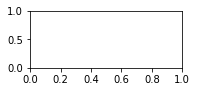

In [42]:
plt.subplot(3,2,1)
plt.subplots_adjust(hspace = 0.4)


(0.5, 1)

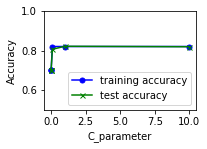

In [43]:
from sklearn.model_selection import validation_curve
C_param_range = [0.001,0.001,0.01,0.1,1,10]
train_sepal_scores, test_sepal_scores = validation_curve(estimator=LogReg
                                                            ,X=data_transformed_xtrain
                                                            ,y=y_train
                                                            ,param_name='C'
                                                            ,param_range=C_param_range
                                                            ,cv=5)

train_sepal_mean = np.mean(train_sepal_scores,axis=1)
train_sepal_std = np.std(train_sepal_scores,axis=1)
test_sepal_mean = np.mean(test_sepal_scores,axis=1)
test_sepal_std = np.std(test_sepal_scores,axis=1)

plt.subplot(2,2,1)
plt.plot(C_param_range
            ,train_sepal_mean
            ,color='blue'
            ,marker='o'
            ,markersize=5
            ,label='training accuracy')
    
plt.plot(C_param_range
            ,test_sepal_mean
            ,color='green'
            ,marker='x'
            ,markersize=5
            ,label='test accuracy') 
    
plt.xlabel('C_parameter')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5,1])


In [44]:
train_sizes=[50, 80, 110]

(0.5, 1)

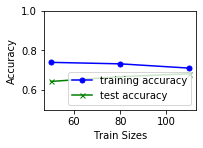

In [45]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(LogReg, data_transformed_xtrain, y_train, train_sizes=[50, 80, 110], cv=5)

train_sepal_mean = np.mean(train_scores,axis=1)
train_sepal_std = np.std(train_scores,axis=1)
test_sepal_mean = np.mean(valid_scores,axis=1)
test_sepal_std = np.std(valid_scores,axis=1)

plt.subplot(2,2,1)
plt.plot(train_sizes
            ,train_sepal_mean
            ,color='blue'
            ,marker='o'
            ,markersize=5
            ,label='training accuracy')
    
plt.plot(train_sizes
            ,test_sepal_mean
            ,color='green'
            ,marker='x'
            ,markersize=5
            ,label='test accuracy') 
    
plt.xlabel('Train Sizes')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5,1])


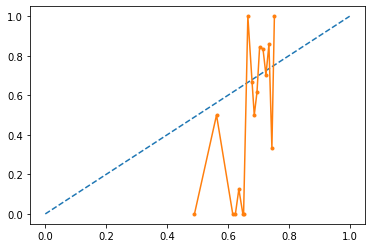

In [46]:
from sklearn.calibration import calibration_curve
probs=LogReg.predict_proba(data_transformed_xtest)[:,1]
fop, mpv = calibration_curve(y_test, probs, n_bins=100)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')

In [47]:
from sklearn.calibration import CalibratedClassifierCV
calibrator = CalibratedClassifierCV(LogReg, cv=3)

calibrator.fit(data_transformed_xtrain,y_train)
yhat = calibrator.predict_proba(data_transformed_xtest)
print(yhat[0:10])

from sklearn.linear_model import LogisticRegression
LogReg=LogisticRegression(C=0.01,penalty='l1')
LogReg
LogReg.fit(data_transformed_xtrain,y_train)
yhat_uncalibrated=LogReg.predict_proba(data_transformed_xtrain)
print(yhat_uncalibrated[0:10])

[[0.23447147 0.76552853]
 [0.22338973 0.77661027]
 [0.25801616 0.74198384]
 [0.29362936 0.70637064]
 [0.25297226 0.74702774]
 [0.25618642 0.74381358]
 [0.22238528 0.77761472]
 [0.19822193 0.80177807]
 [0.27388426 0.72611574]
 [0.21804752 0.78195248]]


ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

In [48]:
calibrator.predict_proba

<bound method CalibratedClassifierCV.predict_proba of CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.01,
                                                         class_weight=None,
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=100,
                                                         multi_class='auto',
                                                         n_jobs=None,
                                                         penalty='l2',
                                                         random_state=None,
                                                         solver='lbfgs',
                                                         tol=0.0001, ve

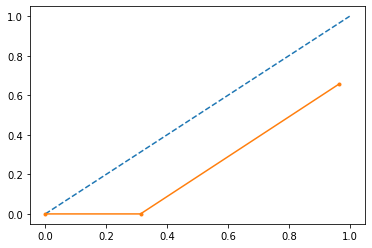

In [49]:
from sklearn.svm import SVC
model = SVC()
model.fit(data_transformed_xtrain,y_train)
# predict probabilities
probs = model.decision_function(data_transformed_xtest)
# reliability diagram
fop, mpv = calibration_curve(y_test, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

In [50]:
model = SVC()
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
calibrated.fit(data_transformed_xtrain,y_train)
# predict probabilities
probs = calibrated.predict_proba(y_test)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

ValueError: could not convert string to float: 'Y'